# SpaceX Falcon Launch Cost Predictor

###1. Description
In this project I'll be predicting the cost of launch using `SpaceX's` Falcon.


###2. Data Sourcing
The data will be procured from SpaceX official website using webscrapping.



### Webscraping Objective
* Request to the SpaceX API
* Clean the requested Data


In [1]:
import pandas as pd
# setting up option to print all columns of df
pd.set_option('display.max_columns',None)
# setting up option to print all data in the feature
pd.set_option('display.max_colwidth',None)
import numpy as np
import requests
import datetime

####Define Helper functions to extract the infomation using `identification numbers` in the launch data.

##### From `Rocket` column we will get the `Booster Name`


In [2]:
def getBoosterVersion(data):
  for x in data['rocket']:
    response = requests.get("https://api.spacexdata.com/v4/rockets/"+str(x)).json()
    BoosterVersion.append(response['name'])

##### From `LaunchPad` column we will get the `longitute and latitude`


In [3]:
def getLaunchSite(data):
  for x in data['launchpad']:
    response = requests.get("https://api.spacexdata.com/v4/launchpads/"+str(x)).json()
    Longitude.append(response['longitude'])
    Latitude.append(response['latitude'])
    LaunchSite.append(response['name'])

##### From the `payload` we can get mass of payload and the orbit

In [4]:
def getPayloadData(data):
  for load in data['payloads']:
    response = requests.get("https://api.spacexdata.com/v4/payloads/"+load).json()
    PayloadMass.append(response['mass_kg'])
    Orbit.append(response["orbit"])

##### From `cores` we can learn 
* outcome of landing
* no. of flights with that core
* Whether gridfins were used
* whether core is reused
* whether legs were used
* the Landing pad used
* the block of the core which is a number used to seperate version of cores
* the number of times this specific core has been reused
* the serial of the core.

In [5]:
def getCoreData(data):
    for core in data['cores']:
            if core['core'] != None:
                response = requests.get("https://api.spacexdata.com/v4/cores/"+core['core']).json()
                Block.append(response['block'])
                ReusedCount.append(response['reuse_count'])
                Serial.append(response['serial'])
            else:
                Block.append(None)
                ReusedCount.append(None)
                Serial.append(None)
            Outcome.append(str(core['landing_success'])+' '+str(core['landing_type']))
            Flights.append(core['flight'])
            GridFins.append(core['gridfins'])
            Reused.append(core['reused'])
            Legs.append(core['legs'])
            LandingPad.append(core['landpad'])

#### Requesting data from SpaceX API

In [6]:
spacex_url = "https://api.spacexdata.com/v4/launches/past"

In [7]:
response = requests.get(spacex_url)
print(response.content)

b'[{"fairings":{"reused":false,"recovery_attempt":false,"recovered":false,"ships":[]},"links":{"patch":{"small":"https://images2.imgbox.com/3c/0e/T8iJcSN3_o.png","large":"https://images2.imgbox.com/40/e3/GypSkayF_o.png"},"reddit":{"campaign":null,"launch":null,"media":null,"recovery":null},"flickr":{"small":[],"original":[]},"presskit":null,"webcast":"https://www.youtube.com/watch?v=0a_00nJ_Y88","youtube_id":"0a_00nJ_Y88","article":"https://www.space.com/2196-spacex-inaugural-falcon-1-rocket-lost-launch.html","wikipedia":"https://en.wikipedia.org/wiki/DemoSat"},"static_fire_date_utc":"2006-03-17T00:00:00.000Z","static_fire_date_unix":1142553600,"net":false,"window":0,"rocket":"5e9d0d95eda69955f709d1eb","success":false,"failures":[{"time":33,"altitude":null,"reason":"merlin engine failure"}],"details":"Engine failure at 33 seconds and loss of vehicle","crew":[],"ships":[],"capsules":[],"payloads":["5eb0e4b5b6c3bb0006eeb1e1"],"launchpad":"5e9e4502f5090995de566f86","flight_number":1,"name

The response recieved above needs to be parsed 
using  `static response object ` to make JSON results more consistent

In [8]:
static_json_url='https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/API_call_spacex_api.json'

In [9]:
response.status_code

200

In [10]:
response = response.json()

In [11]:
data = pd.json_normalize(response)

In [12]:
data.head().T

,0,1,2,3,4
static_fire_date_utc,2006-03-17T00:00:00.000Z,None,None,2008-09-20T00:00:00.000Z,None
static_fire_date_unix,1142553600.0,NaN,NaN,1221868800.0,NaN
net,False,False,False,False,False
window,0.0,0.0,0.0,0.0,0.0
rocket,5e9d0d95eda69955f709d1eb,5e9d0d95eda69955f709d1eb,5e9d0d95eda69955f709d1eb,5e9d0d95eda69955f709d1eb,5e9d0d95eda69955f709d1eb
success,False,False,False,True,True
failures,"[{'time': 33, 'altitude': None, 'reason': 'merlin engine failure'}]","[{'time': 301, 'altitude': 289, 'reason': 'harmonic oscillation leading to premature engine shutdown'}]","[{'time': 140, 'altitude': 35, 'reason': 'residual stage-1 thrust led to collision between stage 1 and stage 2'}]",[],[]
details,Engine failure at 33 seconds and loss of vehicle,"Successful first stage burn and transition to second stage, maximum altitude 289 km, Premature engine shutdown at T+7 min 30 s, Failed to reach orbit, Failed to recover first stage",Residual stage 1 thrust led to collision between stage 1 and stage 2,"Ratsat was carried to orbit on the first successful orbital launch of any privately funded and developed, liquid-propelled carrier rocket, the SpaceX Falcon 1",None
crew,[],[],[],[],[]
ships,[],[],[],[],[]


In [13]:
# Lets take a subset of our dataframe keeping only the features we want and the flight number, and date_utc.
data = data[['rocket', 'payloads', 'launchpad', 'cores', 'flight_number', 'date_utc']]

# We will remove rows with multiple cores because those are falcon rockets with 2 extra rocket boosters and rows that have multiple payloads in a single rocket.
data = data[data['cores'].map(len)==1]
data = data[data['payloads'].map(len)==1]

# Since payloads and cores are lists of size 1 we will also extract the single value in the list and replace the feature.
data['cores'] = data['cores'].map(lambda x : x[0])
data['payloads'] = data['payloads'].map(lambda x : x[0])

# We also want to convert the date_utc to a datetime datatype and then extracting the date leaving the time
data['date'] = pd.to_datetime(data['date_utc']).dt.date

# Using the date we will restrict the dates of the launches
data = data[data['date'] <= datetime.date(2020, 11, 13)]

In [14]:
data.head().T

,0,1,3,4,5
rocket,5e9d0d95eda69955f709d1eb,5e9d0d95eda69955f709d1eb,5e9d0d95eda69955f709d1eb,5e9d0d95eda69955f709d1eb,5e9d0d95eda69973a809d1ec
payloads,5eb0e4b5b6c3bb0006eeb1e1,5eb0e4b6b6c3bb0006eeb1e2,5eb0e4b7b6c3bb0006eeb1e5,5eb0e4b7b6c3bb0006eeb1e6,5eb0e4b7b6c3bb0006eeb1e7
launchpad,5e9e4502f5090995de566f86,5e9e4502f5090995de566f86,5e9e4502f5090995de566f86,5e9e4502f5090995de566f86,5e9e4501f509094ba4566f84
cores,"{'core': '5e9e289df35918033d3b2623', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}","{'core': '5e9e289ef35918416a3b2624', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}","{'core': '5e9e289ef3591855dc3b2626', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}","{'core': '5e9e289ef359184f103b2627', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}","{'core': '5e9e289ef359185f2b3b2628', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}"
flight_number,1,2,4,5,6
date_utc,2006-03-24T22:30:00.000Z,2007-03-21T01:10:00.000Z,2008-09-28T23:15:00.000Z,2009-07-13T03:35:00.000Z,2010-06-04T18:45:00.000Z
date,2006-03-24,2007-03-21,2008-09-28,2009-07-13,2010-06-04


In [15]:
#Global variables 
BoosterVersion = []
PayloadMass = []
Orbit = []
LaunchSite = []
Outcome = []
Flights = []
GridFins = []
Reused = []
Legs = []
LandingPad = []
Block = []
ReusedCount = []
Serial = []
Longitude = []
Latitude = []

In [16]:
getBoosterVersion(data)
# Call getLaunchSite
getLaunchSite(data)

# Call getPayloadData
getPayloadData(data)

# Call getCoreData
getCoreData(data)

In [17]:
launch_dict = {'FlightNumber': list(data['flight_number']),
'Date': list(data['date']),
'BoosterVersion':BoosterVersion,
'PayloadMass':PayloadMass,
'Orbit':Orbit,
'LaunchSite':LaunchSite,
'Outcome':Outcome,
'Flights':Flights,
'GridFins':GridFins,
'Reused':Reused,
'Legs':Legs,
'LandingPad':LandingPad,
'Block':Block,
'ReusedCount':ReusedCount,
'Serial':Serial,
'Longitude': Longitude,
'Latitude': Latitude}



In [18]:
df = pd.DataFrame.from_dict(launch_dict, orient = 'index')

In [19]:
df = df.T

In [20]:
df.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
0,1,2006-03-24,Falcon 1,20,LEO,Kwajalein Atoll,None None,1,False,False,False,None,None,0,Merlin1A,167.743129,9.047721
1,2,2007-03-21,Falcon 1,None,LEO,Kwajalein Atoll,None None,1,False,False,False,None,None,0,Merlin2A,167.743129,9.047721
2,4,2008-09-28,Falcon 1,165,LEO,Kwajalein Atoll,None None,1,False,False,False,None,None,0,Merlin2C,167.743129,9.047721
3,5,2009-07-13,Falcon 1,200,LEO,Kwajalein Atoll,None None,1,False,False,False,None,None,0,Merlin3C,167.743129,9.047721
4,6,2010-06-04,Falcon 9,None,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1,0,B0003,-80.577366,28.561857


In [21]:
data_falcon9 = df[df['BoosterVersion']!='Falcon 1']
data_falcon9.loc[:,'FlightNumber'] = list(range(1, data_falcon9.shape[0]+1))

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value


In [22]:
data_falcon9 = data_falcon9[0:90]

In [23]:
data_falcon9


,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
4,1,2010-06-04,Falcon 9,None,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1,0,B0003,-80.577366,28.561857
5,2,2012-05-22,Falcon 9,525,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1,0,B0005,-80.577366,28.561857
6,3,2013-03-01,Falcon 9,677,ISS,CCSFS SLC 40,None None,1,False,False,False,None,1,0,B0007,-80.577366,28.561857
7,4,2013-09-29,Falcon 9,500,PO,VAFB SLC 4E,False Ocean,1,False,False,False,None,1,0,B1003,-120.610829,34.632093
8,5,2013-12-03,Falcon 9,3170,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1,0,B1004,-80.577366,28.561857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,86,2020-09-03,Falcon 9,15600,VLEO,KSC LC 39A,True ASDS,2,True,True,True,5e9e3032383ecb6bb234e7ca,5,12,B1060,-80.603956,28.608058
90,87,2020-10-06,Falcon 9,15600,VLEO,KSC LC 39A,True ASDS,3,True,True,True,5e9e3032383ecb6bb234e7ca,5,12,B1058,-80.603956,28.608058
91,88,2020-10-18,Falcon 9,15600,VLEO,KSC LC 39A,True ASDS,6,True,True,True,5e9e3032383ecb6bb234e7ca,5,12,B1051,-80.603956,28.608058
92,89,2020-10-24,Falcon 9,15600,VLEO,CCSFS SLC 40,True ASDS,3,True,True,True,5e9e3033383ecbb9e534e7cc,5,12,B1060,-80.577366,28.561857


## Data Wrangling


In [24]:
data_falcon9.isnull().sum()

FlightNumber       0
Date               0
BoosterVersion     0
PayloadMass        5
Orbit              0
LaunchSite         0
Outcome            0
Flights            0
GridFins           0
Reused             0
Legs               0
LandingPad        26
Block              0
ReusedCount        0
Serial             0
Longitude          0
Latitude           0
dtype: int64

In [25]:
data_falcon9.PayloadMass.mean()

6123.547647058824

In [26]:
data_falcon9.PayloadMass.fillna(value = df.PayloadMass.mean(),inplace =True)

In [27]:
data_falcon9.isnull().sum()

FlightNumber       0
Date               0
BoosterVersion     0
PayloadMass        0
Orbit              0
LaunchSite         0
Outcome            0
Flights            0
GridFins           0
Reused             0
Legs               0
LandingPad        26
Block              0
ReusedCount        0
Serial             0
Longitude          0
Latitude           0
dtype: int64

In [28]:
data_falcon9.to_csv('dataset_part\_1.csv', index=False)

## EDA

In [29]:
import numpy as np

In [30]:
df=pd.read_csv("/content/dataset_part\_1.csv")
df.head(10)



,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
0,1,2010-06-04,Falcon 9,5919.165341,LEO,CCSFS SLC 40,None None,1,False,False,False,NaN,1,0,B0003,-80.577366,28.561857
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCSFS SLC 40,None None,1,False,False,False,NaN,1,0,B0005,-80.577366,28.561857
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCSFS SLC 40,None None,1,False,False,False,NaN,1,0,B0007,-80.577366,28.561857
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1,0,B1003,-120.610829,34.632093
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCSFS SLC 40,None None,1,False,False,False,NaN,1,0,B1004,-80.577366,28.561857
5,6,2014-01-06,Falcon 9,3325.000000,GTO,CCSFS SLC 40,None None,1,False,False,False,NaN,1,0,B1005,-80.577366,28.561857
6,7,2014-04-18,Falcon 9,2296.000000,ISS,CCSFS SLC 40,True Ocean,1,False,False,True,NaN,1,0,B1006,-80.577366,28.561857
7,8,2014-07-14,Falcon 9,1316.000000,LEO,CCSFS SLC 40,True Ocean,1,False,False,True,NaN,1,0,B1007,-80.577366,28.561857
8,9,2014-08-05,Falcon 9,4535.000000,GTO,CCSFS SLC 40,None None,1,False,False,False,NaN,1,0,B1008,-80.577366,28.561857
9,10,2014-09-07,Falcon 9,4428.000000,GTO,CCSFS SLC 40,None None,1,False,False,False,NaN,1,0,B1011,-80.577366,28.561857


In [31]:
df.isnull().sum()/df.count()*100

FlightNumber       0.000
Date               0.000
BoosterVersion     0.000
PayloadMass        0.000
Orbit              0.000
LaunchSite         0.000
Outcome            0.000
Flights            0.000
GridFins           0.000
Reused             0.000
Legs               0.000
LandingPad        40.625
Block              0.000
ReusedCount        0.000
Serial             0.000
Longitude          0.000
Latitude           0.000
dtype: float64

In [32]:
df.LaunchSite.value_counts()

CCSFS SLC 40    55
KSC LC 39A      22
VAFB SLC 4E     13
Name: LaunchSite, dtype: int64

In [33]:
df.Orbit.value_counts()

GTO      27
ISS      21
VLEO     14
PO        9
LEO       7
SSO       5
MEO       3
ES-L1     1
HEO       1
SO        1
GEO       1
Name: Orbit, dtype: int64

In [34]:
landing_outcomes = df.Outcome.value_counts()
landing_outcomes

True ASDS      41
None None      19
True RTLS      14
False ASDS      6
True Ocean      5
False Ocean     2
None ASDS       2
False RTLS      1
Name: Outcome, dtype: int64

In [35]:
for i,outcome in enumerate(landing_outcomes.keys()):
    print(i,outcome)

0 True ASDS
1 None None
2 True RTLS
3 False ASDS
4 True Ocean
5 False Ocean
6 None ASDS
7 False RTLS


In [36]:
bad_outcomes=set(landing_outcomes.keys()[[1,3,5,6,7]])
bad_outcomes

{'False ASDS', 'False Ocean', 'False RTLS', 'None ASDS', 'None None'}

In [37]:
landing_class =[]
for i in df.Outcome:
  if i in bad_outcomes:
    landing_class.append(0)
  else:
    landing_class.append(1)


df['Class']=landing_class
df[['Class']].head(8)


,Class
0,0
1,0
2,0
3,0
4,0
5,0
6,1
7,1


In [38]:
df.head(5)

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,5919.165341,LEO,CCSFS SLC 40,None None,1,False,False,False,NaN,1,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCSFS SLC 40,None None,1,False,False,False,NaN,1,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCSFS SLC 40,None None,1,False,False,False,NaN,1,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCSFS SLC 40,None None,1,False,False,False,NaN,1,0,B1004,-80.577366,28.561857,0


In [39]:
df["Class"].mean()

0.6666666666666666

In [40]:
df.to_csv("dataset_part\_2.csv", index=False)

Working with the Refined Data Set


In [41]:
df=pd.read_csv("/content/dataset_part\_2.csv")
df.head(5)

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,5919.165341,LEO,CCSFS SLC 40,None None,1,False,False,False,NaN,1,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCSFS SLC 40,None None,1,False,False,False,NaN,1,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCSFS SLC 40,None None,1,False,False,False,NaN,1,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCSFS SLC 40,None None,1,False,False,False,NaN,1,0,B1004,-80.577366,28.561857,0


In [42]:
import matplotlib.pyplot as plt
import seaborn as sns


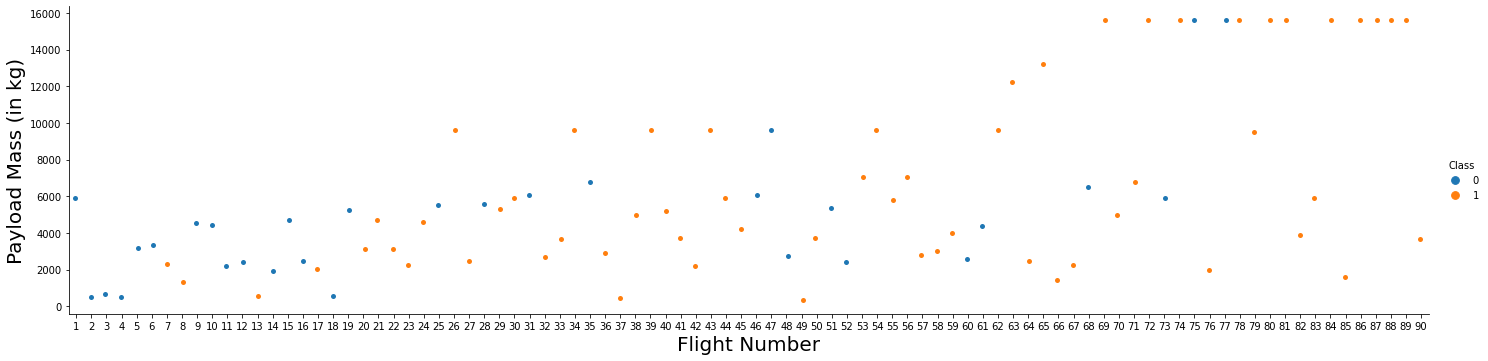

In [43]:
sns.catplot(y = "PayloadMass", x = "FlightNumber",hue = "Class",data = df, aspect = 4)
plt.xlabel('Flight Number',fontsize = 20)
plt.ylabel("Payload Mass (in kg)",fontsize = 20)
plt.show()

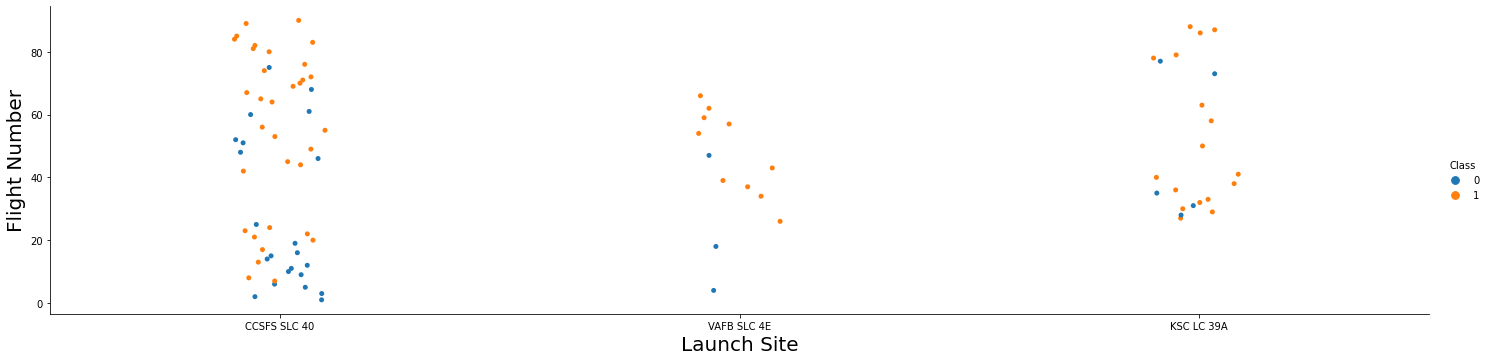

In [44]:
sns.catplot(y = "FlightNumber", x = "LaunchSite",hue = "Class",data = df, aspect = 4)
plt.xlabel('Launch Site',fontsize = 20)
plt.ylabel("Flight Number",fontsize = 20)
plt.show()

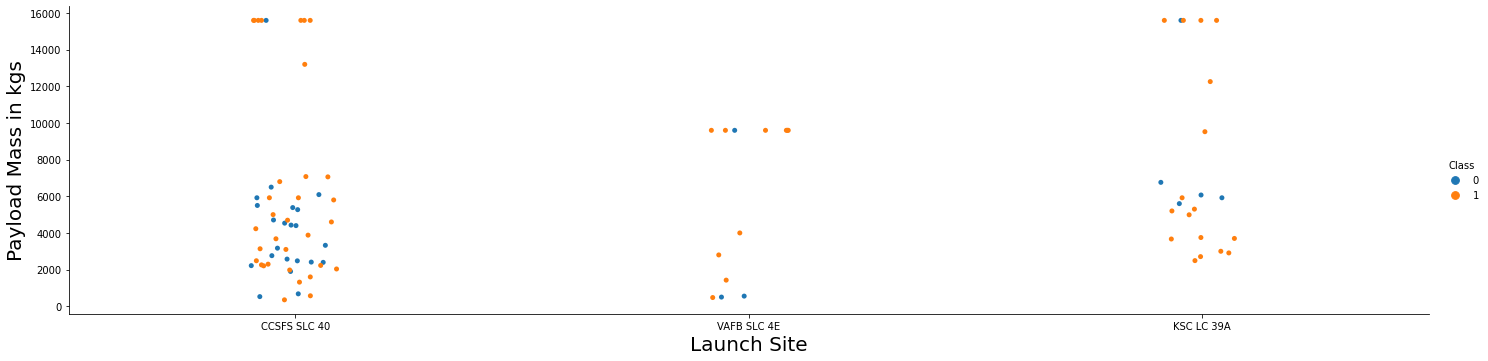

In [45]:
sns.catplot(y = "PayloadMass", x = "LaunchSite",hue = "Class",data = df, aspect = 4)
plt.xlabel('Launch Site',fontsize = 20)
plt.ylabel("Payload Mass in kgs",fontsize = 20)
plt.show()

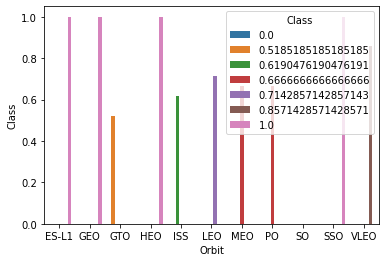

In [46]:
orbit_success = df.groupby(df.Orbit).mean()
orbit_success.reset_index(inplace=True)
sns.barplot(x="Orbit",y="Class",data =orbit_success,hue='Class')

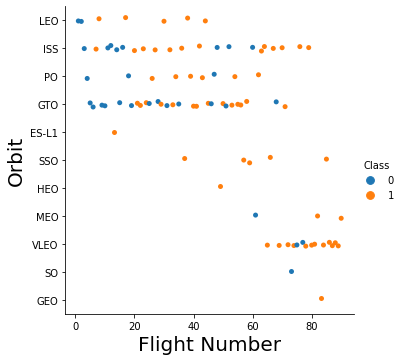

In [47]:
sns.catplot(y = "Orbit", x = "FlightNumber",hue = "Class",data = df)
plt.xlabel('Flight Number',fontsize = 20)
plt.ylabel("Orbit",fontsize = 20)
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

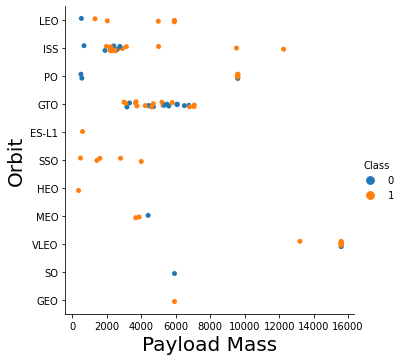

In [48]:
sns.catplot(x = "PayloadMass", y = 'Orbit', data =df ,hue = 'Class')
plt.xlabel("Payload Mass", fontsize = 20)
plt.ylabel("Orbit", fontsize = 20)
plt.show

In [49]:
df.Date = pd.to_datetime(df.Date)

df["years"] = df.Date.dt.year

In [50]:
avg_years = df.groupby(by ="years").mean()
avg_years.reset_index(inplace = True)


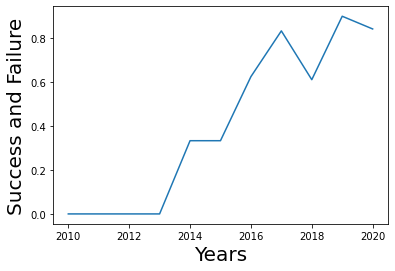

In [51]:
plt.plot(avg_years.years,avg_years.Class)
plt.xlabel("Years",fontsize=20)
plt.ylabel("Success and Failure", fontsize = 20)
plt.show()


## Feature Engineering
Using One Hot Encoder

Get the dummies for categorial columns

In [52]:
features = df[['FlightNumber', 'PayloadMass', 'Orbit', 'LaunchSite', 'Flights', 'GridFins', 'Reused', 'Legs', 'LandingPad', 'Block', 'ReusedCount', 'Serial']]
features.head()


,FlightNumber,PayloadMass,Orbit,LaunchSite,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial
0,1,5919.165341,LEO,CCSFS SLC 40,1,False,False,False,NaN,1,0,B0003
1,2,525.000000,LEO,CCSFS SLC 40,1,False,False,False,NaN,1,0,B0005
2,3,677.000000,ISS,CCSFS SLC 40,1,False,False,False,NaN,1,0,B0007
3,4,500.000000,PO,VAFB SLC 4E,1,False,False,False,NaN,1,0,B1003
4,5,3170.000000,GTO,CCSFS SLC 40,1,False,False,False,NaN,1,0,B1004


In [53]:
features_one_hot=pd.get_dummies(features, columns=['Orbit','LaunchSite', 'LandingPad', 'Serial'])
features_one_hot

,FlightNumber,PayloadMass,Flights,GridFins,Reused,Legs,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,Orbit_LEO,Orbit_MEO,Orbit_PO,Orbit_SO,Orbit_SSO,Orbit_VLEO,LaunchSite_CCSFS SLC 40,LaunchSite_KSC LC 39A,LaunchSite_VAFB SLC 4E,LandingPad_5e9e3032383ecb267a34e7c7,LandingPad_5e9e3032383ecb554034e7c9,LandingPad_5e9e3032383ecb6bb234e7ca,LandingPad_5e9e3032383ecb761634e7cb,LandingPad_5e9e3033383ecbb9e534e7cc,Serial_B0003,Serial_B0005,Serial_B0007,Serial_B1003,Serial_B1004,Serial_B1005,Serial_B1006,Serial_B1007,Serial_B1008,Serial_B1010,Serial_B1011,Serial_B1012,Serial_B1013,Serial_B1015,Serial_B1016,Serial_B1017,Serial_B1018,Serial_B1019,Serial_B1020,Serial_B1021,Serial_B1022,Serial_B1023,Serial_B1025,Serial_B1026,Serial_B1028,Serial_B1029,Serial_B1030,Serial_B1031,Serial_B1032,Serial_B1034,Serial_B1035,Serial_B1036,Serial_B1037,Serial_B1038,Serial_B1039,Serial_B1040,Serial_B1041,Serial_B1042,Serial_B1043,Serial_B1044,Serial_B1045,Serial_B1046,Serial_B1047,Serial_B1048,Serial_B1049,Serial_B1050,Serial_B1051,Serial_B1054,Serial_B1056,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062
0,1,5919.165341,1,False,False,False,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,525.000000,1,False,False,False,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,677.000000,1,False,False,False,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,500.000000,1,False,False,False,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,3170.000000,1,False,False,False,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,86,15600.000000,2,True,True,True,5,12,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
86,87,15600.000000,3,True,True,True,5,12,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
87,88,15600.000000,6,True,True,True,5,12,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
88,89,15600.000000,3,True,True,True,5,12,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [54]:
features_one_hot = features_one_hot.astype('float64')

## GeoSpatial Maps with Folium

In [55]:
!pip install folium
!pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [56]:
import folium
import wget

In [57]:
from folium.plugins import MarkerCluster
from folium.plugins import MousePosition
from folium.features import DivIcon

In [58]:
spacex_csv_file = wget.download('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/spacex_launch_geo.csv')
spacex_df=pd.read_csv(spacex_csv_file)


In [59]:
nasa_coordinate = [29.559684888503615, -95.0830971930759]
site_map = folium.Map(location = nasa_coordinate,zoom_start = 15)


In [60]:
 circle = folium.Circle(nasa_coordinate,radius=1000, color ="#d35400",fill = True).add_child(folium.Popup('NASA Johnson Space Center'))
 marker = folium.map.Marker(
     nasa_coordinate,
     icon = DivIcon(
         icon_size = (20,20),
         icon_anchor = (0,0),
         html = '<div style="font-size: 12; color:#d35400;"><b>%s</b></div>' % 'NASA JSC'
     )
 )

 site_map.add_child(circle)
 site_map.add_child(marker)

In [61]:
spacex_df.head()

,Flight Number,Date,Time (UTC),Booster Version,Launch Site,Payload,Payload Mass (kg),Orbit,Customer,Landing Outcome,class,Lat,Long
0,1,2010-06-04,18:45:00,F9 v1.0 B0003,CCAFS LC-40,Dragon Spacecraft Qualification Unit,0.0,LEO,SpaceX,Failure (parachute),0,28.562302,-80.577356
1,2,2010-12-08,15:43:00,F9 v1.0 B0004,CCAFS LC-40,"Dragon demo flight C1, two CubeSats, barrel of Brouère cheese",0.0,LEO (ISS),NASA (COTS) NRO,Failure (parachute),0,28.562302,-80.577356
2,3,2012-05-22,7:44:00,F9 v1.0 B0005,CCAFS LC-40,Dragon demo flight C2+,525.0,LEO (ISS),NASA (COTS),No attempt,0,28.562302,-80.577356
3,4,2012-10-08,0:35:00,F9 v1.0 B0006,CCAFS LC-40,SpaceX CRS-1,500.0,LEO (ISS),NASA (CRS),No attempt,0,28.562302,-80.577356
4,5,2013-03-01,15:10:00,F9 v1.0 B0007,CCAFS LC-40,SpaceX CRS-2,677.0,LEO (ISS),NASA (CRS),No attempt,0,28.562302,-80.577356


In [62]:
x = spacex_df.groupby("Launch Site").mean()

In [63]:
x.reset_index(inplace = True)

In [64]:
x = x.drop(["Flight Number", "class","Payload Mass (kg)"], axis =1)

In [65]:
x.head()


,Launch Site,Lat,Long
0,CCAFS LC-40,28.562302,-80.577356
1,CCAFS SLC-40,28.563197,-80.576820
2,KSC LC-39A,28.573255,-80.646895
3,VAFB SLC-4E,34.632834,-120.610745


### A function to load all the circles and markers on the Map using `for` loop

In [66]:
siteMap = folium.Map(nasa_coordinate,zoom_start=5)

for index,row in x.iterrows():
  cords = [row["Lat"],row["Long"]]
  cicle = folium.Circle(cords,radius = 10000,fill = True , color = "#d35620").add_child(folium.Popup(row["Launch Site"])).add_to(siteMap)
  marker = folium.Marker(
      cords,
      icon = DivIcon(
          icon_size = (20,20),
          icon_anchor = (0,0),
          html='<div style="font-size: 12; color:#d35400;"><b>%s</b></div>' % row['Launch Site']
          
        )
      ).add_to(siteMap)
 
siteMap

### Marking Success/Failed Launches on the Map

In [67]:
spacex_df = spacex_df[['Launch Site', 'Lat', 'Long', 'class']]
launch_sites_df = spacex_df.groupby(['Launch Site'], as_index=False).first()
launch_sites_df = launch_sites_df[['Launch Site', 'Lat', 'Long']]
launch_sites_df

,Launch Site,Lat,Long
0,CCAFS LC-40,28.562302,-80.577356
1,CCAFS SLC-40,28.563197,-80.576820
2,KSC LC-39A,28.573255,-80.646895
3,VAFB SLC-4E,34.632834,-120.610745


Create a Markercluster object to define green markers for successful launch and red marker for failed launches

In [68]:
marker_cluster  = MarkerCluster()

In [69]:
def assign_marker_color(launch_outcome):
    if launch_outcome == 1:
        return 'green'
    else:
        return 'red'
    
spacex_df['marker_color'] = spacex_df['class'].apply(assign_marker_color)
spacex_df.tail(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,Launch Site,Lat,Long,class,marker_color
46,KSC LC-39A,28.573255,-80.646895,1,green
47,KSC LC-39A,28.573255,-80.646895,1,green
48,KSC LC-39A,28.573255,-80.646895,1,green
49,CCAFS SLC-40,28.563197,-80.576820,1,green
50,CCAFS SLC-40,28.563197,-80.576820,1,green
51,CCAFS SLC-40,28.563197,-80.576820,0,red
52,CCAFS SLC-40,28.563197,-80.576820,0,red
53,CCAFS SLC-40,28.563197,-80.576820,0,red
54,CCAFS SLC-40,28.563197,-80.576820,1,green
55,CCAFS SLC-40,28.563197,-80.576820,0,red


In [70]:
siteMap.add_child(marker_cluster)

for index, row in spacex_df.iterrows():
  cords = [row["Lat"],row["Long"]]
  folium.map.Marker(cords, icon = folium.Icon(color = "white", icon_color = row['marker_color'])).add_to(marker_cluster)
siteMap

#### Calculating distance for proximites

In [71]:
formatter = "function(num) {return L.Util.formatNum(num, 5);};"
mouse_position = MousePosition(
    position='topright',
    separator=' Long: ',
    empty_string='NaN',
    lng_first=False,
    num_digits=20,
    prefix='Lat:',
    lat_formatter=formatter,
    lng_formatter=formatter,
)

siteMap.add_child(mouse_position)
siteMap

In [72]:
from math import sin, cos, sqrt, atan2, radians

def calculate_distance(lat1, lon1, lat2, lon2):
    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance

In [73]:
launch_site_lat = 28.563197
launch_site_lon = -80.576820
coastline_lat = 28.56334
coastline_lon = -80.56799
distance_coastline = calculate_distance(launch_site_lat, launch_site_lon, coastline_lat, coastline_lon)
print(distance_coastline,' km')

0.8627671182499878  km


In [74]:
distance_marker = folium.Marker(
   [coastline_lat, coastline_lon],
   icon=DivIcon(
       icon_size=(20,20),
       icon_anchor=(0,0),
       html='<div style="font-size: 12; color:#d35400;"><b>%s</b></div>' % "{:10.2f} KM".format(distance_coastline),
       )
   )
siteMap.add_child(distance_marker)


In [75]:
coordinates = [[launch_site_lat,launch_site_lon],[coastline_lat,coastline_lon]]
lines=folium.PolyLine(locations=coordinates, weight=1)
siteMap.add_child(lines)




## Modelling and Prediction

In [76]:
from sklearn import preprocessing
# Allows us to split our data into training and testing data
from sklearn.model_selection import train_test_split
# Allows us to test parameters of classification algorithms and find the best one
from sklearn.model_selection import GridSearchCV
# Logistic Regression classification algorithm
from sklearn.linear_model import LogisticRegression
# Support Vector Machine classification algorithm
from sklearn.svm import SVC
# Decision Tree classification algorithm
from sklearn.tree import DecisionTreeClassifier
# K Nearest Neighbors classification algorithm
from sklearn.neighbors import KNeighborsClassifier

In [77]:
## A function to plot confusion matrix
def plot_confusion_matrix(y,y_predict):
    "this function plots the confusion matrix"
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['did not land', 'land']); ax.yaxis.set_ticklabels(['did not land', 'landed'])

In [80]:
data = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_2.csv")
data.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,6104.959412,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0


In [81]:
X = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_3.csv')

# If you were unable to complete the previous lab correctly you can uncomment and load this csv

# X = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/dataset_part_3.csv')

X.head(100)

,FlightNumber,PayloadMass,Flights,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,Orbit_LEO,Orbit_MEO,Orbit_PO,Orbit_SO,Orbit_SSO,Orbit_VLEO,LaunchSite_CCAFS SLC 40,LaunchSite_KSC LC 39A,LaunchSite_VAFB SLC 4E,LandingPad_5e9e3032383ecb267a34e7c7,LandingPad_5e9e3032383ecb554034e7c9,LandingPad_5e9e3032383ecb6bb234e7ca,LandingPad_5e9e3032383ecb761634e7cb,LandingPad_5e9e3033383ecbb9e534e7cc,Serial_B0003,Serial_B0005,Serial_B0007,Serial_B1003,Serial_B1004,Serial_B1005,Serial_B1006,Serial_B1007,Serial_B1008,Serial_B1010,Serial_B1011,Serial_B1012,Serial_B1013,Serial_B1015,Serial_B1016,Serial_B1017,Serial_B1018,Serial_B1019,Serial_B1020,Serial_B1021,Serial_B1022,Serial_B1023,Serial_B1025,Serial_B1026,Serial_B1028,Serial_B1029,Serial_B1030,Serial_B1031,Serial_B1032,Serial_B1034,Serial_B1035,Serial_B1036,Serial_B1037,Serial_B1038,Serial_B1039,Serial_B1040,Serial_B1041,Serial_B1042,Serial_B1043,Serial_B1044,Serial_B1045,Serial_B1046,Serial_B1047,Serial_B1048,Serial_B1049,Serial_B1050,Serial_B1051,Serial_B1054,Serial_B1056,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062,GridFins_False,GridFins_True,Reused_False,Reused_True,Legs_False,Legs_True
0,1.0,6104.959412,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,2.0,525.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,3.0,677.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,4.0,500.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,5.0,3170.000000,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,86.0,15400.000000,2.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
86,87.0,15400.000000,3.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
87,88.0,15400.000000,6.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.

In [85]:
Y = data["Class"].to_numpy()

In [87]:
Y


array([0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1])

##### Transform into Numpy array for ease of training

In [89]:

X.mean(axis = 0)
X.std(axis = 0)

transform  = preprocessing.StandardScaler().fit(X)

X = transform.transform(X)

In [93]:
X.std(axis = 0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

#### Train Test Split

In [94]:
X_train, X_test, Y_train, Y_test =  train_test_split(X,Y,test_size=0.2,random_state=2)

In [97]:

X_test.shape,Y_test.shape

((18, 83), (18,))

In [105]:
parameters ={"C":[0.01,0.1,1],'penalty':['l2'], 'solver':['lbfgs']}# l1 lasso l2 ridge
lr=LogisticRegression()

In [106]:
logreg_cv = GridSearchCV(lr, parameters, cv=10)

In [108]:
logreg_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1], 'penalty': ['l2'],
                         'solver': ['lbfgs']})

In [103]:
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy : 0.8464285714285713


In [110]:
yhat=logreg_cv.predict(X_test)

In [111]:

logreg_cv.score(X_test, Y_test)

0.8333333333333334

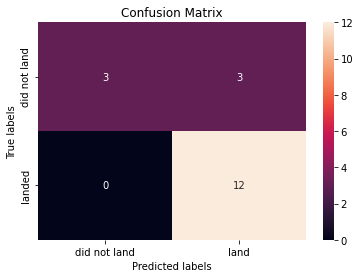

In [112]:
plot_confusion_matrix(Y_test,yhat)

In [113]:
parameters = {'kernel':('linear', 'rbf','poly','rbf', 'sigmoid'),
              'C': np.logspace(-3, 3, 5),
              'gamma':np.logspace(-3, 3, 5)}
svm = SVC()

In [114]:
svm_cv = GridSearchCV(svm, parameters, cv=10)

In [115]:
svm_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'gamma': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'kernel': ('linear', 'rbf', 'poly', 'rbf', 'sigmoid')})

In [116]:
print("tuned hpyerparameters :(best parameters) ",svm_cv.best_params_)
print("accuracy :",svm_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 1.0, 'gamma': 0.03162277660168379, 'kernel': 'sigmoid'}
accuracy : 0.8482142857142856


In [117]:
svm_cv.score(X_test, Y_test)

0.8333333333333334

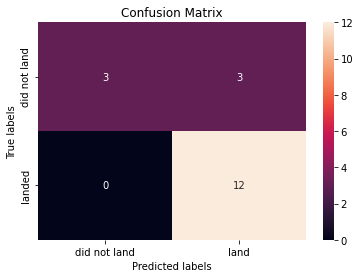

In [118]:
yhat=svm_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

In [119]:
parameters = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]}

tree = DecisionTreeClassifier()

In [120]:

tree_cv = GridSearchCV(tree, parameters, cv=10)

In [121]:

tree_cv.fit(X_train,Y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'splitter': ['best', 'random']})

In [122]:
print("tuned hpyerparameters :(best parameters) ",tree_cv.best_params_)
print("accuracy :",tree_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'criterion': 'entropy', 'max_depth': 14, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'random'}
accuracy : 0.9017857142857142


In [123]:

tree_cv.score(X_test,Y_test)

0.7777777777777778

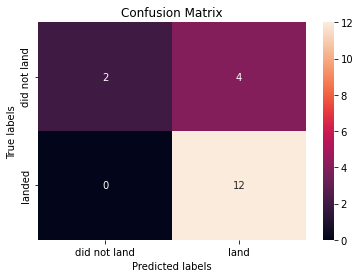

In [124]:

yhat = tree_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

In [125]:
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}

KNN = KNeighborsClassifier()

In [126]:

knn_cv = GridSearchCV(KNN, parameters, cv=10)

In [127]:

knn_cv.fit(X_train,Y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'p': [1, 2]})

In [128]:
print("tuned hpyerparameters :(best parameters) ",knn_cv.best_params_)
print("accuracy :",knn_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'n_neighbors': 10, 'p': 1}
accuracy : 0.8482142857142858


In [129]:

knn_cv.score(X_test,Y_test)

0.8333333333333334

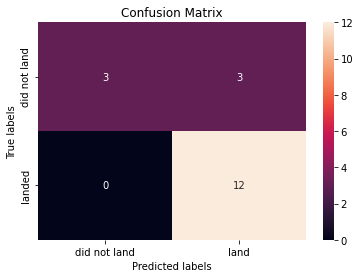

In [130]:
yhat = knn_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)